In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(os.getcwd())
from pathlib import Path
# folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
folder = Path(r'../../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder, folder.exists())
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*2e*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

/home/rmcd/git/onhm-fetcher-parser-2/notebooks/final_notebooks
../../Data_v1_1 True
               LAYER            GM_TYPE  OBJECTID  nhru_v11  hru_segme1  \
0       NHM\nhru_v11  Unknown Area Type         1     76127       40038   
1       NHM\nhru_v11  Unknown Area Type         2     76147       40038   
2       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
3       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
4       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
...              ...                ...       ...       ...         ...   
139802  NHM\nhru_v11  Unknown Area Type    114954     57964       31028   
139803  NHM\nhru_v11  Unknown Area Type    114955     64080       28886   
139804  NHM\nhru_v11  Unknown Area Type    114956     64150       28866   
139805  NHM\nhru_v11  Unknown Area Type    114957     65633       31412   
139806  NHM\nhru_v11  Unknown Area Type    114958     18843       10081   

        Shape_L

In [3]:
import requests
from requests.exceptions import HTTPError

# delete existing file if it exists
gmfile = Path('../../Data_v1_1/test_gm.nc')
exists = gmfile.exists()
if exists:
#     ds.close()
    os.remove(gmfile)
    print('removed existing file')

# # Url for non-aggragated
# url = r'http://thredds.northwestknowledge.net:8080/thredds/ncss/MET/tmmn/tmmn_2019.nc'
# payload={'var': 'air_temperature',
#         'north': '49.4000',
#         'west': '-124.7666',
#         'east': '-67.0583',
#         'south': '25.0666',
#         'horizStride': '1',
#         'time_start': '2018-12-31T00:00:00Z',
#         'time_end': '2018-12-31T00:00:00Z',
#         'timeStride': '1',
#         'accept': 'netcdf4'}
# Note: when using the non-aggragated server, asking for dates in previous year fails.  Indicates
# that using the aggragated server would be the way to go when traversing a new calander year.
# http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-01-01T00%3A00%3A00Z&time_end=2019-01-01T00%3A00%3A00Z&timeStride=1&accept=netcdf
# Url for aggragated
url2 = 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc'
payload2={'var': 'daily_maximum_temperature',
        'disableLLSubset': 'on',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': '2018-12-31T00:00:00Z',
        'time_end': '2018-12-31T00:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf'}
# print(url)
try:
#     myfile = requests.get(url, params=payload)
    myfile = requests.get(url2, params=payload2)
    myfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Python 3.6
except Exception as err:
    print(f'Other error occurred: {err}')  # Python 3.6
else:
    print('Success!')
#     print(myfile.headers)
    print(myfile.url)
        
with open(gmfile, 'wb') as fh:
    fh.write(myfile.content)
    fh.close()

ds = xr.open_dataset(gmfile)
print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
# datahandle=ds['air_temperature'] # for non aggragated download
datahandle=ds['daily_maximum_temperature'] # for aggragated download
# crshandle=ds['crs']
# print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
# print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

removed existing file
Success!
http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00%3A00%3A00Z&time_end=2018-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf
<xarray.Dataset>
Dimensions:                    (day: 1, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2018-12-31
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -1

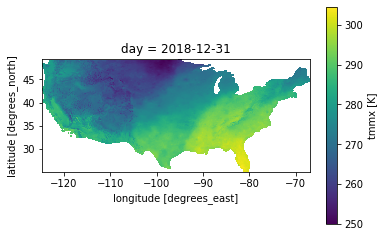

In [4]:
tmax = ds.daily_maximum_temperature.isel(day=[0])
# p = tmax.plot(col = 'time', aspect = ds.dims['x']/ds.dims['y'], size = 2)
p = tmax.plot()
p.axes.set_aspect('equal')
plt.show()

   grid_ids  nhru_v11         w
0    638227     76127  0.030892
1    638228     76127  0.011476
2    638226     76127  0.094655
3    638225     76127  0.095469
4    636842     76127  0.017072
wegh_id nhru_v11
[nan nan nan ... nan nan nan]
139807 113313
returning masked value 82923
returning masked value 82970
returning masked value 82982
returning masked value 82983
returning masked value 104387
returning masked value 96094
returning masked value 96095
returning masked value 96105
returning masked value 96105
returning masked value 96111
returning masked value 96119
returning masked value 96120
returning masked value 96122
returning masked value 96124
returning masked value 96124
returning masked value 96124
returning masked value 96130
returning masked value 96134
returning masked value 96135
returning masked value 96140
returning masked value 96141
returning masked value 96144
returning masked value 96149
returning masked value 96159
returning masked value 96159
returning masked valu

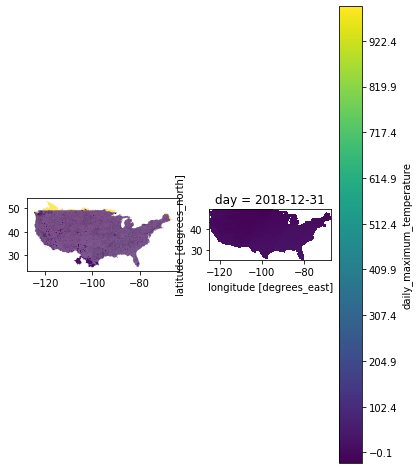

In [17]:

from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../../Data_v1_1/tmp_Gridmet_weights_hru_v1_1e.csv')
print(wght_UofI.head())
wghts_id = wght_UofI.columns[1]
print('wegh_id', wghts_id)
#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

print(ndata[1000:])
hru_id = 'nhru_v11'
unique_hru_ids = wght_UofI.groupby(wghts_id)
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        print('returning masked value', hru_id)
        return 1273.5 #np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row[wghts_id])
#         td[index] = np_get_wval2(weight_id_rows, ndata) - 273.5
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, row[wghts_id]) - 273.5)
    except KeyError:
#         print('keyerror', row[wghts_id])
        td[index] = 1000.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

f, ax = plt.subplots(1, 2, figsize=(6,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[0].set_aspect('equal', 'box')
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
p=temp.plot(ax=ax[1], levels=lvs, cmap='viridis')
ax[1].set_aspect('equal','box')


In [34]:
oc_hru = gdf.loc[gdf['tmax'] == 1000.0]
oc_hru[wghts_id].head()

4113     82923
4201     82970
4230     82982
4231     82983
8564    104387
Name: nhru_v11, dtype: int64

In [47]:
wght_sum = wght_UofI.groupby(wghts_id).sum()
print(type(wght_sum))
print(wght_sum.head())
# temp = wght_sum.where(wght_sum[wghts_id].index not in oc_hru[wghts_id])
print(wght_sum.index[0])

<class 'pandas.core.frame.DataFrame'>
          grid_ids         w
nhru_v11                    
1          1385235  1.000000
2          1105414  1.000000
3           275660  1.000000
4           551321  0.999999
5          1106812  1.000000
1


          grid_ids         w
nhru_v11                    
1          1385235  1.000000
2          1105414  1.000000
3           275660  1.000000
4           551321  0.999999
5          1106812  1.000000
...            ...       ...
96          518053  1.000000
97          235589  1.000000
98         1044450  1.000000
99          807691  1.000000
100        1077846  1.000000

[100 rows x 2 columns]


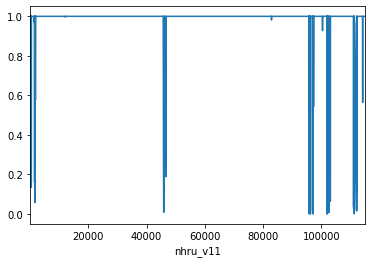

In [43]:
print(wght_sum.head(100))
wght_sum['w'][10000]
wght_sum.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

dropped 82923
dropped 82970
dropped 82982
dropped 82983
dropped 104387
dropped 96094
dropped 96095
dropped 96105
96105
dropped 96111
dropped 96119
dropped 96120
dropped 96122
dropped 96124
96124
96124
dropped 96130
dropped 96134
dropped 96135
dropped 96140
dropped 96141
dropped 96144
dropped 96149
dropped 96159
96159
96159
dropped 96164
dropped 96165
dropped 96167
dropped 96168
dropped 96171
dropped 96172
dropped 96173
dropped 96174
dropped 96175
dropped 96180
dropped 96181
dropped 96187
dropped 96190
dropped 96201
dropped 96204
dropped 96205
dropped 96209
dropped 96215
dropped 96219
dropped 96222
dropped 96234
dropped 96244
dropped 96248
dropped 96254
96255
dropped 96260
dropped 101849
dropped 101855
dropped 101856
dropped 101862
dropped 101863
dropped 101869
dropped 101876
dropped 101877
dropped 101878
dropped 101881
dropped 101885
dropped 101888
dropped 101892
dropped 101894
101894
101894
dropped 101896
dropped 101897
dropped 101898
101898
dropped 101899
dropped 101900
dropped 10190

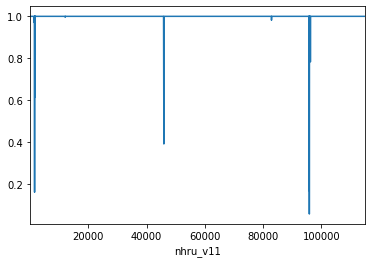

In [61]:
wght_sum = wght_UofI.groupby(wghts_id).sum()
for row in oc_hru[wghts_id]:
#     print(row)
    try:
        wght_sum.drop(index=row, inplace = True)
        print('dropped', row)
    except(KeyError):
        print(row)
wght_sum.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

In [64]:
print(wght_sum.w[wght_sum.w < .999])

nhru_v11
1481     0.969404
1526     0.756070
1530     0.675895
1545     0.597526
1547     0.159950
1718     0.612796
1774     0.881916
1781     0.816150
12054    0.995970
45840    0.952552
45850    0.986147
45863    0.991613
45937    0.390380
82895    0.981461
95734    0.866284
95770    0.167433
95796    0.796050
95797    0.871531
95802    0.705611
95822    0.244176
95891    0.055769
96257    0.782445
Name: w, dtype: float64


```
nhru_v11
1481     0.969404 # has two polygons separated by some disance one lies outside of gridmet
1526     0.756070 # part outside of gridmet
1530     0.675895 # part outside of gridmet
1545     0.597526 # part outside of gridmet
1547     0.159950 # part outside of gridmet
1718     0.612796 # part outside of gridmet
1774     0.881916 # part outside of gridmet
1781     0.816150 # part outside of gridmet
12054    0.995970 # part outside of gridmet
45840    0.952552 # part outside of gridmet
45850    0.986147 # not sure why the weight is not 1.0 - it's in the middle of conus
45863    0.991613 # part outside of gridmet
45937    0.390380  # part outside of gridmet
82895    0.981461 # part outside of gridmet
95734    0.866284 # part outside of gridmet
95770    0.167433 # part outside of gridmet
95796    0.796050  # part outside of gridmet
95797    0.871531 # part outside of gridmet
95802    0.705611 # part outside of gridmet
95822    0.244176 # part outside of gridmet
95891    0.055769 # part outside of gridmet
96257    0.782445 # part outside of gridmet
```

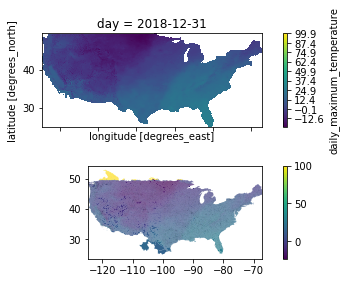

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f, ax = plt.subplots(2, 1, sharex=True)

lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)

p=temp.plot(ax=ax[0], levels=lvs, cmap='viridis')
ax[0].set_aspect('equal', 'box')

g = gdf.plot(ax=ax[1], column = 'tmax',linewidth=0., edgecolor='white', legend=True)
temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[1].set_aspect('equal', 'box')


plt.tight_layout()
plt.show()

In [37]:
print(wght_UofI.head(6))

   grid_ids  hru_id_nat         w
0    278433           1  0.000120
1    277046           1  0.031155
2    277047           1  0.901587
3    277048           1  0.046570
4    275661           1  0.020568
5    277046           2  0.131723


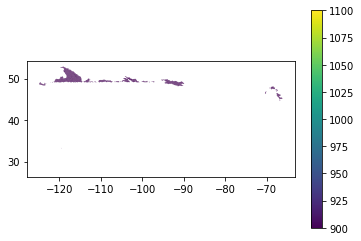

In [18]:
g = gdf.loc[(gdf['tmax'] == 1000.0)].plot(column = 'tmax',linewidth=0., edgecolor='white', legend=True)


In [19]:
oc_hru = gdf.loc[gdf['tmax'] == 1000.0]

In [25]:
oc_hru[wghts_id].to_csv('oc_hru.csv', index=False, header=['nhru_v11'])